# **I. Introduction**


Name : Monica M. Pratiwi
<br>
Batch : FTDS-016-RMT


## **Query pada Google Cloud Platform**

The data used is the `ml_datasets` data from a database named `census_adult_income`.
<br>
The query created has the following criteria:
1. The selected fields are `age`, `workclass`, `education`, `education_num`, `marital_status`, `occupation`, `relationship`, `race`, `sex`, `capital_gain`, `capital_loss`, `hours_per_week`, `native_country` and `income_bracket`.
2. Select all `workclass`, except `?`.
3. Select `hours_per_week` less than 100.
4. Limit the amount of data to the batch number multiplied by the year of birth. For batch 16 and born in 1998, the limit value is 16 x 1998 = 31968.

**Query**

In [ ]:
# Insert Query

#select * except(functional_weight) from `bigquery-public-data.ml_datasets.census_adult_income`a
#where a.workclass not like '%?'
#and a.hours_per_week < 100
#limit 31968


## **Objective**

Create a classification model using Logistic Regression and SVM to predict the `income bracket`

# **II. Import Libraries**

In [ ]:
# Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import array 
from scipy import stats

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTENC
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
#from sklearn.feature_selection import SelectKBest, chi2, f_classif

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import HalvingGridSearchCV

import joblib
import json

import warnings
warnings.filterwarnings("ignore")

In [ ]:
!pip install feature-engine

from feature_engine.outliers import Winsorizer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 290 kB 22.8 MB/s 


# **III. Data Loading**

The selected data is then saved under the name `h8dsft_P1G2_monica_pratiwi` in .csv format on Google Drive. Next, a dataframe is created using the data with the name `data`.

In [ ]:
# Loading Dataset

data = pd.read_csv('/content/drive/MyDrive/bq-results-20221109-120149-1667995351434/h8dsft_P1G2_monica_pratiwi.csv')


The data that has been called is then shown the first 5 lines and the last 5 lines.

In [ ]:
# Show the head of the data

data.head(5)


,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
0,18,Never-worked,Some-college,10,Never-married,?,Own-child,White,Male,0,0,4,United-States,<=50K
1,37,Private,12th,8,Married-civ-spouse,Sales,Wife,Asian-Pac-Islander,Female,0,0,33,?,<=50K
2,39,Self-emp-not-inc,HS-grad,9,Married-civ-spouse,Sales,Wife,Black,Female,0,0,54,Dominican-Republic,>50K
3,29,Private,HS-grad,9,Married-civ-spouse,Sales,Wife,White,Female,0,0,18,United-States,<=50K
4,64,Private,HS-grad,9,Married-civ-spouse,Sales,Wife,White,Female,0,0,21,United-States,<=50K


In [ ]:
# Show the tail of the data

data.tail(5)

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
30720,50,Self-emp-inc,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,70,Germany,<=50K
30721,21,Private,Some-college,10,Never-married,Machine-op-inspct,Own-child,White,Female,0,0,70,United-States,<=50K
30722,32,Private,Some-college,10,Separated,Machine-op-inspct,Unmarried,Black,Female,0,0,70,United-States,<=50K
30723,39,Private,HS-grad,9,Divorced,Machine-op-inspct,Not-in-family,Black,Female,0,0,70,United-States,<=50K
30724,20,Private,Some-college,10,Never-married,Machine-op-inspct,Not-in-family,White,Male,0,0,70,United-States,<=50K


At first glance, it looks like there are 14 columns and 30725. To turn it off, check the shape and size of the dataset.

In [ ]:
# Find the data shape

print('data shape : ', data.shape)
print('data size  : ', data.size)

data shape :  (30725, 14)
data size  :  430150


There are 430150 information available in this data.
<br>
<br>
Next, a data check is carried out.

In [ ]:
# Check Dataset - 1

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30725 entries, 0 to 30724
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             30725 non-null  int64 
 1   workclass       30725 non-null  object
 2   education       30725 non-null  object
 3   education_num   30725 non-null  int64 
 4   marital_status  30725 non-null  object
 5   occupation      30725 non-null  object
 6   relationship    30725 non-null  object
 7   race            30725 non-null  object
 8   sex             30725 non-null  object
 9   capital_gain    30725 non-null  int64 
 10  capital_loss    30725 non-null  int64 
 11  hours_per_week  30725 non-null  int64 
 12  native_country  30725 non-null  object
 13  income_bracket  30725 non-null  object
dtypes: int64(5), object(9)
memory usage: 3.3+ MB


Of the 14 columns, there are 5 columns with integer data types and the rest are objects. At a glance, there are no missing values, but when examining the first 5 rows, a value of '?' is found in several columns, indicating unknown data values or in other words a missing value.

In [ ]:
# Duplicate data

data_2 = data.copy()

Furthermore, data duplication is carried out so that there is backup data if there is a problem with the data. The backup data is named `data_2`.

In [ ]:
# Check Dataset - 2
data.describe()

,age,education_num,capital_gain,capital_loss,hours_per_week
count,30725.000000,30725.000000,30725.000000,30725.000000,30725.000000
mean,38.439512,10.129699,1105.785094,88.889959,40.946461
std,13.119665,2.562702,7497.027762,405.613208,11.987385
min,17.000000,1.000000,0.000000,0.000000,1.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000
75%,47.000000,13.000000,0.000000,0.000000,45.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000


Next, other data checks were conducted. It is known that the average population is in productive age. The average population has the latest *college* level education. The average number of hours worked in a week is 40 hours.

# **IV. Exploratory Data Analysis (EDA)**

In [ ]:
# Function to create histogram and boxplot.

def diagnostic_plots(df, variable):
    # Define figure size
    plt.figure(figsize=(16, 4))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(df[variable], kde=True, bins=30)
    plt.title('Histogram')

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()

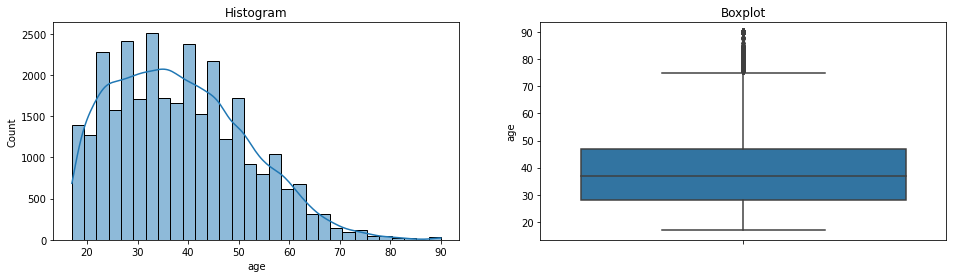


Skewness Value :  0.5316675402543493


In [ ]:
# Distribution of variable `age`

diagnostic_plots(data, 'age')
print('\nSkewness Value : ', data['age'].skew())

A few people are 70 years old and older and should be in their retirement age. The average age of the people are 38 years old which is a working age.

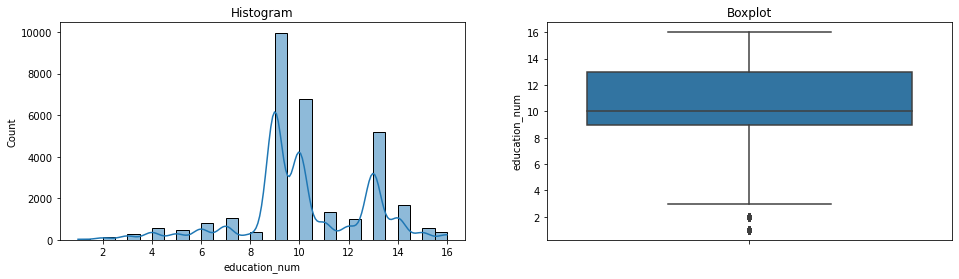


Skewness Value :  -0.31025823520678597


In [ ]:
# Distribution of variable `education_num`

diagnostic_plots(data, 'education_num')
print('\nSkewness Value : ', data['education_num'].skew())

Majority of the people are graduated from high school. With skewness value -0.3, 'education_num' considered normally distributed.

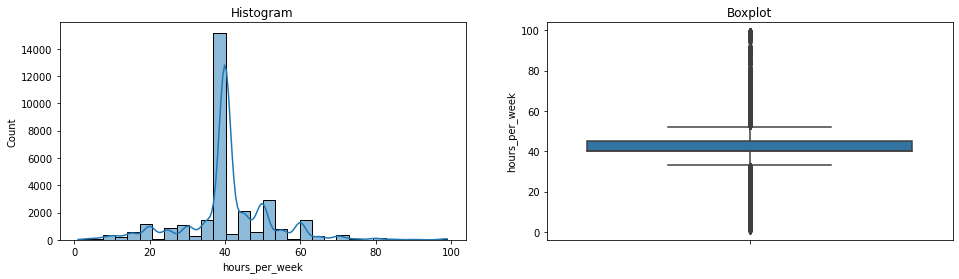


Skewness Value :  0.3307490496608131


In [ ]:
# Distribution of variable `hours_per_week`

diagnostic_plots(data, 'hours_per_week')
print('\nSkewness Value : ', data['hours_per_week'].skew())

The majority of the population works 40 hours per week or 8 hours a day if Saturday and Sunday are not working which is likely to be a 9-5 job. With skewness value 0.3, 'hours_per_week' considered normally distributed.

Next, we will find out the jobs most people have.

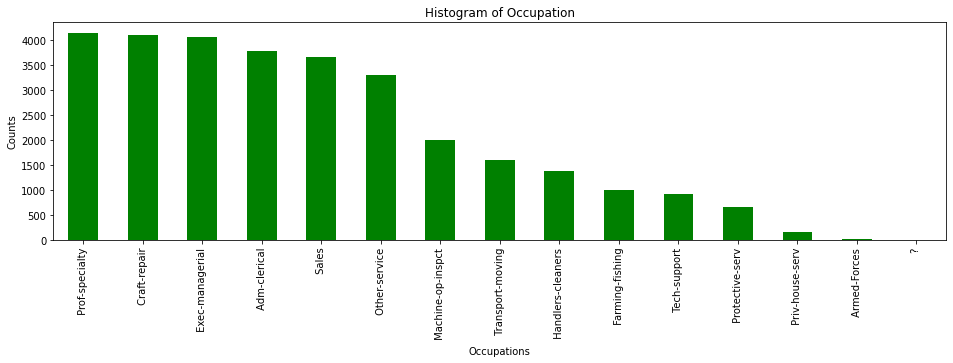

In [ ]:
# Occupation of People

data_occu=data['occupation'].value_counts()
data_occu.plot(kind='bar', figsize=(16, 4), color='green')

plt.title('Histogram of Occupation') 
plt.ylabel('Counts') 
plt.xlabel('Occupations') 

plt.show()

Most people work in prof-specialty field and only small number of people work in security field. There is also an unknown occupation, symbolized by question mark.

Text(0.5, 1.0, 'Income Bracket')

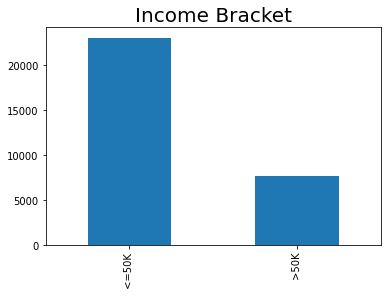

In [ ]:
# Value counts of `income_bracket`

data['income_bracket'].value_counts().plot(kind="bar")
plt.title('Income Bracket', fontsize = 20)

Most of the people have income bracket less than or equal to 50K. Comparison of the number of people who earn <=50K and >50K is imbalance. The model will be difficult to predict the people who earn >50K because the amount of data available is not enough for model to study.

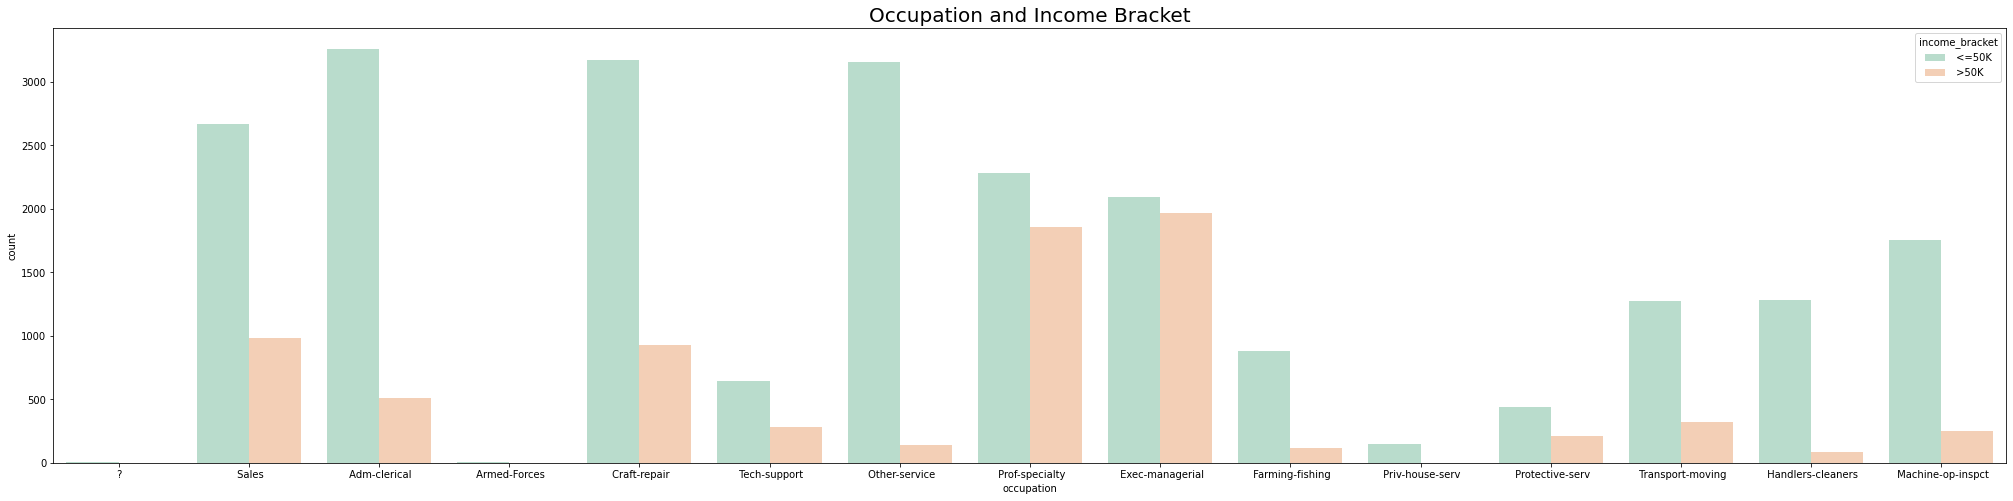

In [ ]:
# Occupation and Income Bracket

plt.figure(figsize=(35,8))
ax = sns.countplot(data=data, x="occupation", hue="income_bracket", palette='Pastel2')
plt.title('Occupation and Income Bracket', fontsize = 20)
plt.show()

Most people who earn more than 50000 work in Prof-Specialty and Exec-managerial field.

In [ ]:
# Number of people based on education

data.groupby(["education_num", "education"]).size()

education_num  education    
1               Preschool         46
2               1st-4th          156
3               5th-6th          303
4               7th-8th          574
5               9th              463
6               10th             833
7               11th            1057
8               12th             393
9               HS-grad         9969
10              Some-college    6777
11              Assoc-voc       1321
12              Assoc-acdm      1020
13              Bachelors       5182
14              Masters         1675
15              Prof-school      558
16              Doctorate        398
dtype: int64

'education_num' represents the level of education mentioned in column 'education'. Only a few number of people  who have preschool as their last education.

Next, find out about which country most people come from.

In [ ]:
# Find the top 5 native country of people 

data['native_country'].value_counts().head(5)

 United-States    27511
 Mexico             610
 ?                  556
 Philippines        188
 Germany            128
Name: native_country, dtype: int64

The amount of people come from USA are enormous. There are also many people with unknown native country.

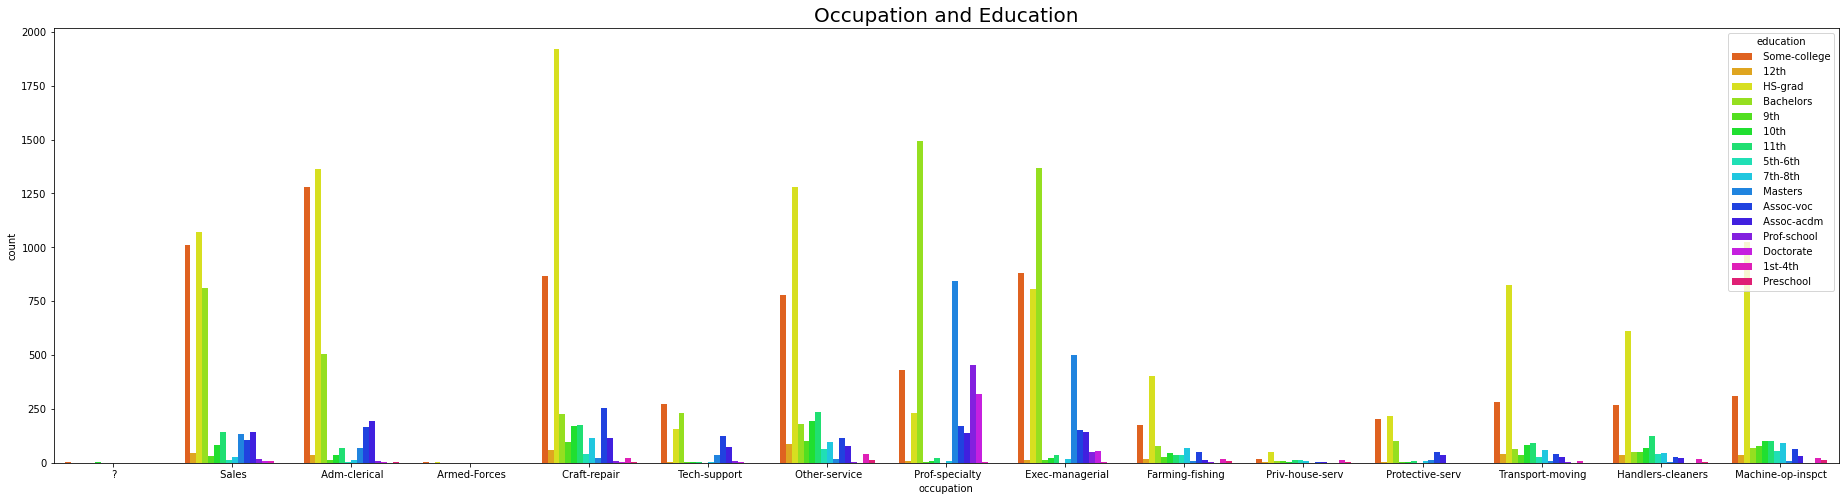

In [ ]:
# Occupation and Income Bracket

plt.figure(figsize=(32,8))
sns.countplot(data=data, x="occupation", hue="education", palette='hsv')
plt.title('Occupation and Education', fontsize = 20)
plt.show()

High school graduates dominate in sales, administration/clerical, craft-repairment, other-service, farming-fishing, priv-house-service, protective service, transportation-moving, handlers-cleaners, and machine-op-inspect. Job that have more employees with higher education level are prof-specialty occupation and exec-managerial. The amount of people graduate from some-college are in between high school graduates and bachelors and tend to gather in industry that mostly accept high number of high school graduate.

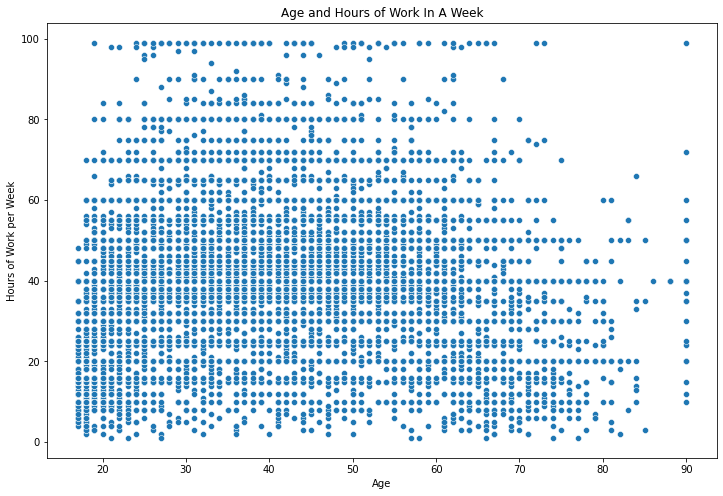

In [ ]:
# Scatter Plot of `age` and `hours_per_week`

plt.figure(figsize=(12,8))
sns.scatterplot(x='age', y='hours_per_week', data=data)
plt.title('Age and Hours of Work In A Week')
plt.xlabel('Age')
plt.ylabel('Hours of Work per Week')
plt.show()

Most people in age between 20 and 60 work between 35-50 hours per week.

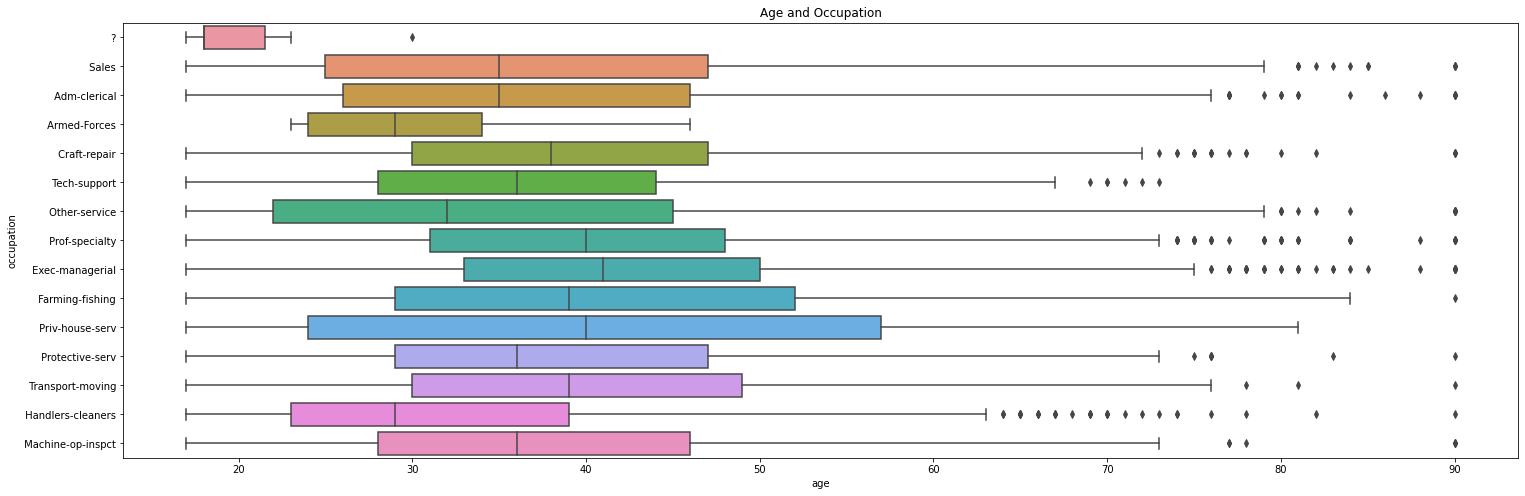

In [ ]:
# Age and Occupation Boxplot

x = data['age']
y = data['occupation']

plt.figure(figsize=(25,8))
sns.boxplot(x, y)
plt.title('Age and Occupation')
plt.show()

most occupation employ senior citizen except armed-forces, tech support, and priv-hourse-service. 

# **V. Data Preprocessing**

In [ ]:
# Get data for model inference

data_inference = data.sample(15, random_state=63)

In [ ]:
# Remove inference set from dataset

data_train_test = data.drop(data_inference.index)

In [ ]:
# Reset Index

data_train_test.reset_index(drop=True, inplace=True)
data_inference.reset_index(drop=True, inplace=True)

## **Splitting Between X (Feature) and y (Target)**

In [ ]:
# Splitting between `X ` AND `y`

X = data_train_test.drop(['income_bracket'], axis=1) 
y = data_train_test['income_bracket']
X.head()

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country
0,18,Never-worked,Some-college,10,Never-married,?,Own-child,White,Male,0,0,4,United-States
1,37,Private,12th,8,Married-civ-spouse,Sales,Wife,Asian-Pac-Islander,Female,0,0,33,?
2,39,Self-emp-not-inc,HS-grad,9,Married-civ-spouse,Sales,Wife,Black,Female,0,0,54,Dominican-Republic
3,29,Private,HS-grad,9,Married-civ-spouse,Sales,Wife,White,Female,0,0,18,United-States
4,64,Private,HS-grad,9,Married-civ-spouse,Sales,Wife,White,Female,0,0,21,United-States


In [ ]:
# Splitting between Train-Set dengan Test-Set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
print('Train Size: ', X_train.shape)
print('Test Size: ', X_test.shape)

Train Size:  (24568, 13)
Test Size:  (6142, 13)


## **Handling Missing Values**

In [ ]:
# Check missing values

X_train.isna().sum()

age               0
workclass         0
education         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
dtype: int64

In [ ]:
X_test.isna().sum()

age               0
workclass         0
education         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
dtype: int64

In [ ]:
y_train.isna().sum()

0

In [ ]:
y_test.isna().sum()

0

Symbol '?' on `occupation` and `native_country` is not detected as a missing value.

In [ ]:
# Find rows with `occupation` and `native_country` contains '?' 

missing = data_train_test[data_train_test["occupation"].str.contains("\?", na=False)]
missing2 = data_train_test[data_train_test["native_country"].str.contains("\?", na=False)]
missing2

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
1,37,Private,12th,8,Married-civ-spouse,Sales,Wife,Asian-Pac-Islander,Female,0,0,33,?,<=50K
47,39,Private,HS-grad,9,Married-civ-spouse,Sales,Husband,Asian-Pac-Islander,Male,0,0,26,?,<=50K
98,39,Private,Some-college,10,Married-civ-spouse,Sales,Husband,White,Male,0,0,26,?,<=50K
197,48,Self-emp-inc,HS-grad,9,Divorced,Sales,Unmarried,Asian-Pac-Islander,Female,0,0,84,?,<=50K
356,26,Private,HS-grad,9,Never-married,Adm-clerical,Own-child,Asian-Pac-Islander,Male,0,0,80,?,>50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30522,55,State-gov,Doctorate,16,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0,0,70,?,>50K
30553,45,Self-emp-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Wife,Asian-Pac-Islander,Female,0,0,70,?,<=50K
30658,51,Federal-gov,Some-college,10,Married-civ-spouse,Protective-serv,Husband,Asian-Pac-Islander,Male,0,0,70,?,<=50K
30701,38,Self-emp-not-inc,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,70,?,<=50K


## **Resampling**

In [ ]:
sm = SMOTENC(random_state=12, categorical_features=[1, 2, 4, 5, 6, 7, 8, 12])
X_train, y_train = sm.fit_resample(X_train, y_train)

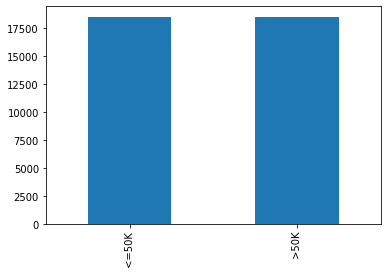

In [ ]:
# Comparison between classes in `y_train`

plot=y_train.value_counts().plot(kind="bar")

## **Handling Outlier**

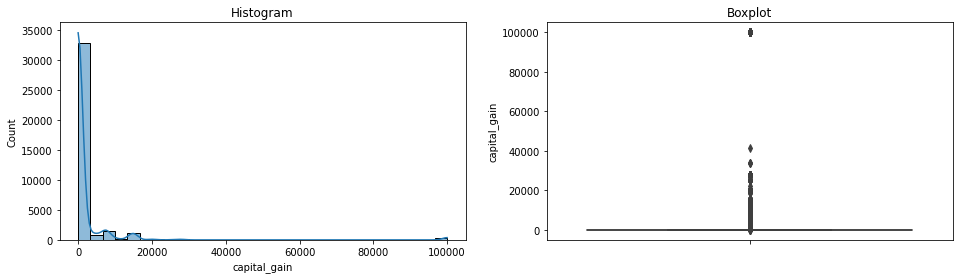


Skewness Value :  8.525487657929304


In [ ]:
#Histogram and Boxplot for `capital_gain`
diagnostic_plots(X_train, 'capital_gain')
print('\nSkewness Value : ', X_train['capital_gain'].skew())

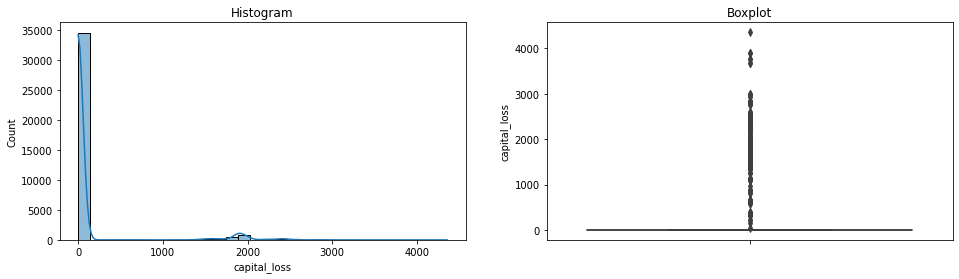


Skewness Value :  3.7464422059260696


In [ ]:
# Histogram and Boxplot for `capital_loss`
diagnostic_plots(X_train, 'capital_loss')
print('\nSkewness Value : ', X_train['capital_loss'].skew())

The `capital_gain` and `capital_loss` data are among the data with high outliers. The value of the upper and lower limits will be calculated.

In [ ]:
# Function to find upper and lower boundaries for skewed distributed variables

def find_skewed_boundaries(df, variable, distance):
    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)

    lower_boundary = df[variable].quantile(0.25) - (IQR * distance)
    upper_boundary = df[variable].quantile(0.75) + (IQR * distance)

    return upper_boundary, lower_boundary

In [ ]:
# Boundaries IQR * 1.5, for `capital_gain` in the X_train dataset
capital_gain_upper_boundary, capital_gain_lower_boundary = find_skewed_boundaries(X_train, 'capital_gain', 1.5)
capital_gain_upper_boundary, capital_gain_lower_boundary

# Boundaries IQR * 1.5, for `capital_loss` in the X_train dataset
capital_loss_upper_boundary, capital_loss_lower_boundary = find_skewed_boundaries(X_train, 'capital_loss', 1.5)
capital_loss_upper_boundary, capital_loss_lower_boundary


print('capital_gain_upper_boundary : ', capital_gain_upper_boundary)
print('capital_gain_lower_boundary : ', capital_gain_lower_boundary, '\n')
print('capital_loss_upper_boundary : ', capital_loss_upper_boundary)
print('capital_loss_lower_boundary : ', capital_loss_lower_boundary, '\n')



capital_gain_upper_boundary :  0.0
capital_gain_lower_boundary :  0.0 

capital_loss_upper_boundary :  0.0
capital_loss_lower_boundary :  0.0 



The upper and lower limits are 0. This is reasonable because not everyone has financial assets that can be used for both short and long term investments.
<br>
The outlier values in the `age`, `education_num` and `hours_per_week` columns will then be censored (capping) using Winsorizer.

In [ ]:
# Create the capper

winsorize = Winsorizer(capping_method='iqr', # choose iqr for IQR rule boundaries or gaussian for mean and std
                          tail='both', # cap left, right or both tails 
                          fold=1.5,
                          variables=['age'])

winsorize.fit(X_train)

X_train_cap = winsorize.transform(X_train)
X_test_cap = winsorize.transform(X_test)

In [ ]:
# Inspect the minimum caps for each variable

print('Left Tail Caps  : ', winsorize.left_tail_caps_)


# Inspect the maximum caps for each variable

print('Right Tail Caps : ', winsorize.right_tail_caps_)

Left Tail Caps  :  {'age': -0.5}
Right Tail Caps :  {'age': 75.5}


In [ ]:
# Data Summary of `X_train` and `X_test` Before and After Capping 

print('X_train - Before Capping')
print(X_train.describe())
print('')
print('X_train - After Capping')
print(X_train_cap.describe())
print('')
print('')
print('X_test - Before Capping')
print(X_test.describe())
print('')
print('X_test - After Capping')
print(X_test_cap.describe())

X_train - Before Capping
                age  education_num  capital_gain  capital_loss  hours_per_week
count  24568.000000   24568.000000  24568.000000  24568.000000    24568.000000
mean      38.414319      10.136519   1071.052385     90.318015       40.873779
std       13.107015       2.559681   7305.343391    409.120613       12.011385
min       17.000000       1.000000      0.000000      0.000000        1.000000
25%       28.000000       9.000000      0.000000      0.000000       40.000000
50%       37.000000      10.000000      0.000000      0.000000       40.000000
75%       47.000000      13.000000      0.000000      0.000000       45.000000
max       90.000000      16.000000  99999.000000   4356.000000       99.000000

X_train - After Capping
                age  education_num  capital_gain  capital_loss  hours_per_week
count  24568.000000   24568.000000  24568.000000  24568.000000    24568.000000
mean      38.380637      10.136519   1071.052385     90.318015       40.873779
st

Age in `X_train` - Before Capping


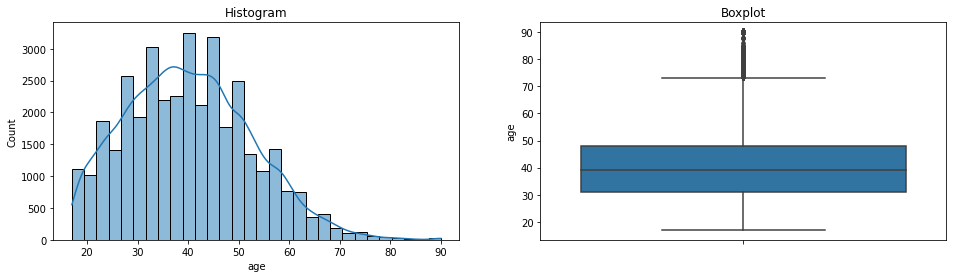

Skewness Value :  0.37274397346618093 


Age in `X_train` - After Capping


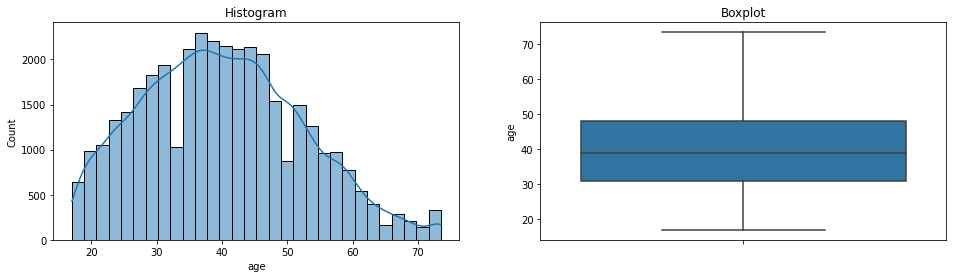

Skewness Value :  0.30079999327167284


In [ ]:
# Distribution plot of `Age` in `X_train` before and after capping

print('Age in `X_train` - Before Capping')
diagnostic_plots(X_train, 'age')
print('Skewness Value : ', X_train['age'].skew(), '\n')
print('')
print('Age in `X_train` - After Capping')
diagnostic_plots(X_train_cap, 'age')
print('Skewness Value : ', X_train_cap['age'].skew())


The outliers in the skewed feature have been capped and the data distribution is normal.

## **Split Numerical and Categorical Columns**

In [ ]:
# Get Numerical Columns and Categorical Columns
numerical =  X_train.select_dtypes(include=np.number).columns.tolist()
categorical = X_train_cap.select_dtypes(include=['object']).columns.tolist()

print('Numerical Columns : ', numerical)
print('Categorical Columns : ', categorical)

Numerical Columns :  ['age', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']
Categorical Columns :  ['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country']


In [ ]:
# Split Train-Set and Test-Set based on Column Types

X_train_num = X_train_cap[numerical]
X_test_num = X_test_cap[numerical]

X_train_cat = X_train_cap[categorical]
X_test_cat = X_test_cap[categorical]

## **Feature Scaling**

In [ ]:
# Scaling for skewed numerical features

scaler = MinMaxScaler()
X_train_num_scaled = scaler.fit_transform(X_train_num)
X_test_num_scaled = scaler.transform(X_test_num)
X_train_num_scaled

array([[0.15929204, 0.53333333, 0.        , 0.        , 0.39795918],
       [0.31858407, 0.8       , 0.        , 0.        , 0.39795918],
       [0.60176991, 0.53333333, 0.        , 0.        , 0.39795918],
       ...,
       [0.30088496, 0.8       , 0.        , 0.        , 0.39795918],
       [0.38938053, 0.73333333, 0.08614086, 0.        , 0.40816327],
       [0.61946903, 0.86666667, 0.07298073, 0.        , 0.39795918]])

## **Feature Encoding**

In [ ]:
# Feature encoding for categorical features

encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
X_train_cat_encoded = encoder.fit_transform(X_train_cat)
X_test_cat_encoded = encoder.transform(X_test_cat)
X_train_cat_encoded

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

In [ ]:
# Define the name of all features in non-ordinal categorical features

b = encoder.get_feature_names_out()

## **Concate between Numerical Columns and Categorical Columns**

In [ ]:
X_train_final = np.concatenate([X_train_num_scaled, X_train_cat_encoded], axis=1)
X_test_final = np.concatenate([X_test_num_scaled, X_test_cat_encoded], axis=1)
X_train_final

array([[0.15929204, 0.53333333, 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.31858407, 0.8       , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.60176991, 0.53333333, 0.        , ..., 1.        , 0.        ,
        0.        ],
       ...,
       [0.30088496, 0.8       , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.38938053, 0.73333333, 0.08614086, ..., 1.        , 0.        ,
        0.        ],
       [0.61946903, 0.86666667, 0.07298073, ..., 1.        , 0.        ,
        0.        ]])

In [ ]:
# Create DataFrame of `X_train_final`

X_train_final_df = pd.DataFrame(X_train_final)

# **VI. Logistic Regression**

Data target merupakan data categorical maka digunakan logistic regression atau logit.

In [ ]:
# Model Definition

logreg_model = LogisticRegression(C=0.07, fit_intercept=True)

In [ ]:
# Train the Model

logreg_model.fit(X_train_final,y_train)

LogisticRegression(C=0.07)

In [ ]:
# Predict Train-Set and Test-Set 

logreg_pred_train = logreg_model.predict(X_train_final)
logreg_pred_test = logreg_model.predict(X_test_final)

In [ ]:
#Predict Probability

prob=logreg_model.predict_proba(X_test_final)
prob

array([[0.54570318, 0.45429682],
       [0.91969762, 0.08030238],
       [0.77631698, 0.22368302],
       ...,
       [0.26753237, 0.73246763],
       [0.04499846, 0.95500154],
       [0.20303262, 0.79696738]])

In [ ]:
# Model Evaluation
print('accuracy score train : ',accuracy_score(y_train,logreg_pred_train))
print('accuracy score test : ',accuracy_score(y_test,logreg_pred_test))

accuracy score train :  0.8338203463203463
accuracy score test :  0.8026701400195376


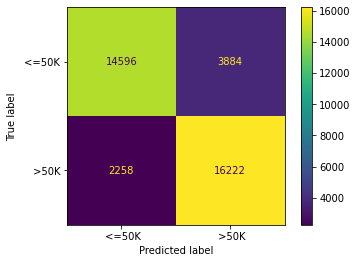

In [ ]:
# Confusion Matrix for `y_train`

cm = confusion_matrix(y_train, logreg_pred_train, labels=logreg_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=logreg_model.classes_)

disp.plot()
plt.show()

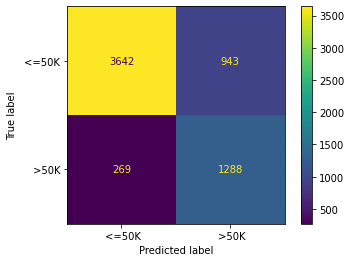

In [ ]:
# Confusion Matrix for `y_test`

cm = confusion_matrix(y_test, logreg_pred_test, labels=logreg_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=logreg_model.classes_)

disp.plot()
plt.show()

In [ ]:
# Classification Report for `y-train`

print(classification_report(y_train,logreg_pred_train))

              precision    recall  f1-score   support

       <=50K       0.87      0.79      0.83     18480
        >50K       0.81      0.88      0.84     18480

    accuracy                           0.83     36960
   macro avg       0.84      0.83      0.83     36960
weighted avg       0.84      0.83      0.83     36960



In [ ]:
# Classification Report for `y-test`
print(classification_report(y_test,logreg_pred_test))

              precision    recall  f1-score   support

       <=50K       0.93      0.79      0.86      4585
        >50K       0.58      0.83      0.68      1557

    accuracy                           0.80      6142
   macro avg       0.75      0.81      0.77      6142
weighted avg       0.84      0.80      0.81      6142



Model has a precision of 0.93—meaning that, when it predicts people who earn <=50K, it is correct 93% of the time. There are 7% residents who are predicted to be in the income category <=50K are in fact not residents in that income category (False Positive). The model also has poor performance when it predicts people who earn >50K, it can only be correct 58% of the time.There are 42% of the population who should be in the <=50K income class, but based on the prediction results, they are in the >50K income class.
<br>
<br>
Recall score implies that This model correctly identifies 79% of all people who earn <=50K and 83% of all people who earn >50K. Comparing to the training set, the model still considered as a good fit.

The percentage of prediction error which is still quite high is of course worrying if this income class data is then used as a reference for financial aid. Residents who should not have received financial aid because of high incomes would receive it. This will certainly be very detrimental because the aid is given to people who are not supposed to receive it.

# **VII. SVM**

In [ ]:
# Model Definition

model_svm = SVC(C=10.0, kernel='rbf', probability=False, degree=3, random_state=72)

In [ ]:
# Model Training

model_svm.fit(X_train_final, y_train)

SVC(C=10.0, random_state=72)

In [ ]:
# Predict Train-Set and Test-Set 

y_pred_train = model_svm.predict(X_train_final)
y_pred_test = model_svm.predict(X_test_final)

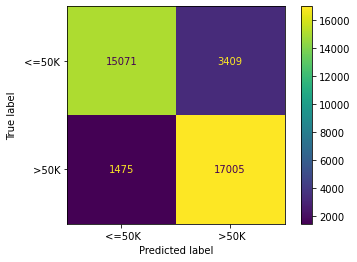

In [ ]:
# Confusion Matrix for `y_train`

cm = confusion_matrix(y_train, y_pred_train, labels=logreg_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=logreg_model.classes_)

disp.plot()
plt.show()

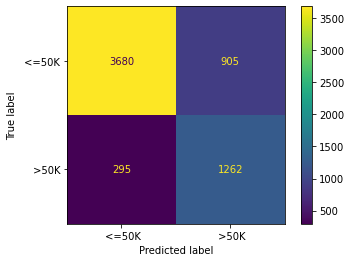

In [ ]:
# Confusion Matrix for `y_test`

cm = confusion_matrix(y_test, y_pred_test, labels=logreg_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=logreg_model.classes_)

disp.plot()
plt.show()

In [ ]:
# Classification Report for `y-train`

print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

       <=50K       0.91      0.82      0.86     18480
        >50K       0.83      0.92      0.87     18480

    accuracy                           0.87     36960
   macro avg       0.87      0.87      0.87     36960
weighted avg       0.87      0.87      0.87     36960



In [ ]:
# Classification Report for `y-test`

print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

       <=50K       0.93      0.80      0.86      4585
        >50K       0.58      0.81      0.68      1557

    accuracy                           0.80      6142
   macro avg       0.75      0.81      0.77      6142
weighted avg       0.84      0.80      0.81      6142



The use of the SVM model with a C (Regularization parameter) value of 10 produces a higher precision value in the train data compared to the logistic regression model. However, the test results are no different, so the model is considered as overfit.

Based on the performance of the test set, SVM does a better job than logistic regression. The next step will be increasing the performance of SVM Model using Hyperparameter Tuning.

## **Hyperparameter Tuning**

In [ ]:
# Hyperparameter Tuning using Halving GridSearchCV
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']} 
print(param_grid)

{'C': [0.1, 1, 10, 100, 1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf']}


In [ ]:
# Initialize the HalvingGridSearchCV 

search = HalvingGridSearchCV(SVC(probability=True, degree=3, random_state=72), param_grid, cv= 3, scoring="accuracy", refit = True, verbose = 3)

In [ ]:
# Fitting the model for halving grid search

search.fit(X_train_final, y_train)

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 4106
max_resources_: 36960
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 25
n_resources: 4106
Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV 1/3] END C=0.1, gamma=1, kernel=rbf;, score=(train=0.807, test=0.684) total time=   4.1s
[CV 2/3] END C=0.1, gamma=1, kernel=rbf;, score=(train=0.734, test=0.781) total time=   4.5s
[CV 3/3] END C=0.1, gamma=1, kernel=rbf;, score=(train=0.764, test=0.761) total time=   4.3s
[CV 1/3] END C=0.1, gamma=0.1, kernel=rbf;, score=(train=0.799, test=0.750) total time=   2.7s
[CV 2/3] END C=0.1, gamma=0.1, kernel=rbf;, score=(train=0.749, test=0.781) total time=   3.1s
[CV 3/3] END C=0.1, gamma=0.1, kernel=rbf;, score=(train=0.776, test=0.794) total time=   2.9s
[CV 1/3] END C=0.1, gamma=0.01, kernel=rbf;, score=(train=0.786, test=0.751) total time=   5.4s
[CV 2/3] END C=0.1, gamma=0.01, kernel=rbf;, score=(train=0.747, test=0.778)

HalvingGridSearchCV(cv=3, estimator=SVC(probability=True, random_state=72),
                    param_grid={'C': [0.1, 1, 10, 100, 1000],
                                'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                                'kernel': ['rbf']},
                    scoring='accuracy', verbose=3)

In [ ]:
# Check the best score
print(search.score(X_test_final, y_test))

0.7990882448713774


In [ ]:
search.best_score_

0.8343075174541322

In [ ]:
# Train new Model
model = search.best_estimator_
model.fit(X_train_final, y_train)


SVC(C=100, gamma=0.1, probability=True, random_state=72)

In [ ]:
# Predict using new model
model_train = model.predict(X_train_final)
model_test = model.predict(X_test_final)

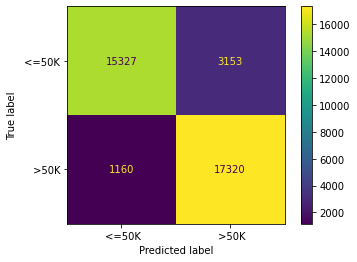

In [ ]:
# Confusion Matrix for `y_train`

cm = confusion_matrix(y_train, model_train, labels=logreg_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=logreg_model.classes_)

disp.plot()
plt.show()

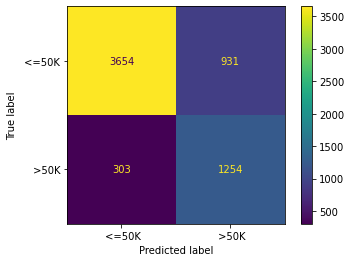

In [ ]:
# Confusion Matrix for `y_test`

cm = confusion_matrix(y_test, model_test, labels=logreg_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=logreg_model.classes_)

disp.plot()
plt.show()

In [ ]:
# Classification Report for `y-train`

print(classification_report(y_train, model_train))

              precision    recall  f1-score   support

       <=50K       0.93      0.83      0.88     18480
        >50K       0.85      0.94      0.89     18480

    accuracy                           0.88     36960
   macro avg       0.89      0.88      0.88     36960
weighted avg       0.89      0.88      0.88     36960



In [ ]:
# Classification Report for `y-test`

print(classification_report(y_test, model_test))

              precision    recall  f1-score   support

       <=50K       0.92      0.80      0.86      4585
        >50K       0.57      0.81      0.67      1557

    accuracy                           0.80      6142
   macro avg       0.75      0.80      0.76      6142
weighted avg       0.83      0.80      0.81      6142



# **VII. Model Saving & Loading**

In [ ]:
# Save the Files

import joblib
import json

with open('model_svm_improved.pkl', 'wb') as file_1:
  joblib.dump(model, file_1)

with open('model_scaler.pkl', 'wb') as file_2:
  joblib.dump(scaler, file_2)

with open('model_encoder.pkl', 'wb') as file_3:
  joblib.dump(encoder, file_3)

with open('list_num_columns.txt', 'w') as file_4:
  json.dump(numerical, file_4)

with open('list_cat_columns.txt', 'w') as file_5:
  json.dump(categorical, file_5)

In [ ]:
# Load All Files

import joblib
import json

with open('model_svm_improved.pkl', 'rb') as file_1:
  model = joblib.load(file_1)

with open('model_scaler.pkl', 'rb') as file_2:
  scaler = joblib.load(file_2)

with open('model_encoder.pkl', 'rb') as file_3:
  encoder = joblib.load(file_3)

with open('list_num_columns.txt', 'r') as file_4:
  numerical = json.load(file_4)

with open('list_cat_columns.txt', 'r') as file_5:
  categorical = json.load(file_5)

# **IX. Model Inference**

In [ ]:
# Get data Inference

data_inference

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
0,39,Private,HS-grad,9,Never-married,Farming-fishing,Unmarried,White,Male,0,0,40,United-States,<=50K
1,21,Private,9th,5,Never-married,Other-service,Own-child,White,Female,0,0,50,Mexico,<=50K
2,27,Private,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States,<=50K
3,28,Private,10th,6,Never-married,Farming-fishing,Other-relative,White,Male,0,0,35,Mexico,<=50K
4,21,Private,Some-college,10,Never-married,Prof-specialty,Not-in-family,White,Female,0,0,40,United-States,<=50K
5,39,Self-emp-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,60,United-States,>50K
6,30,Private,Some-college,10,Married-civ-spouse,Adm-clerical,Wife,White,Female,0,0,40,United-States,<=50K
7,57,Local-gov,Masters,14,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,50,United-States,>50K
8,28,Local-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,Black,Female,4101,0,60,United-States,<=50K
9,64,Private,HS-grad,9,Married-civ-spouse,Other-service,Husband,White,Male,0,0,40,United-States,<=50K


In [ ]:
# Split between Numerical Columns and Categorical Columns

data_inf_num = data_inference[numerical]
data_inf_cat = data_inference[categorical]

In [ ]:
# Feature Scaling and Feature Encoding

num_scaled = scaler.transform(data_inf_num)
cat_encoded = encoder.transform(data_inf_cat)

In [ ]:
# Concate Numerical Columns and Categorical Columns

data_inf_final = np.concatenate([num_scaled, cat_encoded], axis=1)
data_inf_final

array([[0.38938053, 0.53333333, 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.07079646, 0.26666667, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.17699115, 0.8       , 0.        , ..., 1.        , 0.        ,
        0.        ],
       ...,
       [0.65486726, 0.6       , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.37168142, 0.6       , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.05309735, 0.6       , 0.        , ..., 1.        , 0.        ,
        0.        ]])

In [ ]:
# Predict using SVM

y_pred = model.predict(data_inf_final)
y_pred

array([' <=50K', ' <=50K', ' <=50K', ' <=50K', ' <=50K', ' >50K', ' >50K',
       ' >50K', ' <=50K', ' <=50K', ' >50K', ' >50K', ' >50K', ' >50K',
       ' <=50K'], dtype=object)

In [ ]:
# Create DataFrame

y_pred_df = pd.DataFrame(y_pred, columns=['Income_Bracket_Prediction'])
y_pred_df.head()

,Income_Bracket_Prediction
0,<=50K
1,<=50K
2,<=50K
3,<=50K
4,<=50K


In [ ]:
# Concate between Inference-Set and Rating's Prediction

fin = pd.concat([data_inference, y_pred_df], axis=1)
fin.tail()

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_bracket,Income_Bracket_Prediction
10,40,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Sales,Husband,White,Male,0,0,45,United-States,>50K,>50K
11,54,Local-gov,Some-college,10,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,52,United-States,<=50K,>50K
12,54,Private,Some-college,10,Married-civ-spouse,Tech-support,Husband,White,Male,0,1977,18,United-States,>50K,>50K
13,38,Private,Some-college,10,Married-civ-spouse,Sales,Husband,White,Male,0,0,60,United-States,>50K,>50K
14,20,Private,Some-college,10,Never-married,Handlers-cleaners,Own-child,White,Male,0,0,20,United-States,<=50K,<=50K


In [ ]:
# Compare the actual and prediction result side by side

result = pd.concat([data_inference['income_bracket'], y_pred_df], axis=1)
result

,income_bracket,Income_Bracket_Prediction
0,<=50K,<=50K
1,<=50K,<=50K
2,<=50K,<=50K
3,<=50K,<=50K
4,<=50K,<=50K
5,>50K,>50K
6,<=50K,>50K
7,>50K,>50K
8,<=50K,<=50K
9,<=50K,<=50K


# **X. Conclusion**

In this case, the `income_bracket` data which is the target has only 2 classes (<=50K and >50K) and the classes are in categorical data type. The Logistic Regression method is suitable for predicting data types with this data type. Targets that have 2 classes are also suitable if predicted using SVM.
<br>
<br>
The precision value was chosen in the model evaluation because it does not want a false positive value. When compared between the two, the use of SVM increases the precision of values on the train data compared to logistic regression but for the data test there is not much difference.
<br>
<br>
As for the process of working on the model, the selection of SVC as done is not suitable for large datasets like this data because although it has better performance generally than logistic regression, it takes a long time to process the data.

# **Additional Questions**

1. What is coefficient in logistic regression?
   <br>**Answer:** In logistic regression, it is difficult to interpret the coefficient because the form of the equation is the natural logarithm of logistic probability, so *Odds Ratio* is used.

2. What is a Support Vector in SVM?
   <br>**Answer:** Super Vector is the data closest to the hyperplane. The formation of a hyperplane will be greatly influenced by the data closest to the hyperplane.

3. What is the function of kernel parameters in SVM? Explain one of the kernels that you understand!
   <br>**Answer:** The function of the kernel is to determine the type/shape of the separator. The form of the separator consists of Linear for straight lines (not mapped to a higher dimension), polynomial for winding / twisting, and the default is the rbf function for mapping to infinite space.